<a href="https://colab.research.google.com/github/dbright123/Dbot-Advance/blob/main/lstm_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import MetaTrader5 as mt5
import numpy as np
import pandas as pd





In [2]:
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__)

trade_active = mt5.initialize()

print(trade_active)

if not trade_active:
    print('Initialization failed, check internet connection. You must have Meta Trader 5 installed.')
    mt5.shutdown()

else:
    print(mt5.account_info()._asdict())
    print("\n")
    print(mt5.terminal_info()._asdict())
    print("\n")
    print(mt5.symbols_total())

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4200
True
{'login': 213644473, 'trade_mode': 0, 'leverage': 1000, 'limit_orders': 500, 'margin_so_mode': 0, 'trade_allowed': True, 'trade_expert': True, 'margin_mode': 2, 'currency_digits': 2, 'fifo_close': False, 'balance': 200.0, 'credit': 0.0, 'profit': 0.0, 'equity': 200.0, 'margin': 0.0, 'margin_free': 200.0, 'margin_level': 0.0, 'margin_so_call': 25.0, 'margin_so_so': 15.0, 'margin_initial': 0.0, 'margin_maintenance': 0.0, 'assets': 0.0, 'liabilities': 0.0, 'commission_blocked': 0.0, 'name': 'micheal bright omage ', 'server': 'OctaFX-Demo', 'currency': 'USD', 'company': 'Octa Markets Incorporated'}


{'community_account': False, 'community_connection': False, 'connected': True, 'dlls_allowed': False, 'trade_allowed': True, 'tradeapi_disabled': False, 'email_enabled': False, 'ftp_enabled': False, 'notifications_enabled': False, 'mqid': True, 'build': 5370, 'maxbars': 100000000, 'codepage': 0, 'ping_last

In [3]:
account = mt5.account_info()
terminal = mt5.terminal_info()

print(account.equity)

if(terminal.connected == True or terminal.trade_allowed == True):
    print("AI is successfully functional")
else:
    print("Please make sure metatrade 5 has internet and algo Trade is Turn On")

200.0
AI is successfully functional


In [3]:
symbols = mt5.symbols_get()
print(len(symbols))
t_symbol = []
for symbol in symbols:
    if "US" in symbol.name:
        print("Yes ", symbol.name)
        t_symbol.append(symbol.name)

print(len(t_symbol))

280
Yes  EURUSD
Yes  GBPUSD
Yes  USDJPY
Yes  USDCHF
Yes  AUDUSD
Yes  NZDUSD
Yes  USDCAD
Yes  USDMXN
Yes  USDZAR
Yes  XAGUSD
Yes  XAUUSD
Yes  XBRUSD
Yes  XTIUSD
Yes  XNGUSD
Yes  AUS200
Yes  EUSTX50
Yes  US30
Yes  BTCUSD
Yes  ETHUSD
Yes  LTCUSD
Yes  XRPUSD
Yes  BCHUSD
Yes  AAVEUSD
Yes  ADAUSD
Yes  ALGOUSD
Yes  ATOMUSD
Yes  AVAXUSD
Yes  AXSUSD
Yes  BNBUSD
Yes  DASHUSD
Yes  DOGEUSD
Yes  DOTUSD
Yes  FILUSD
Yes  GRTUSD
Yes  ICPUSD
Yes  IOTAUSD
Yes  LINKUSD
Yes  LRCUSD
Yes  MANAUSD
Yes  NEARUSD
Yes  SOLUSD
Yes  UNIUSD
Yes  ZECUSD
Yes  ETCUSD
Yes  TRXUSD
Yes  FETUSD
Yes  ARBUSD
Yes  APTUSD
Yes  SUIUSD
Yes  TMUS.NAS
Yes  USDDKK
Yes  USDCZK
Yes  USDHUF
Yes  USDNOK
Yes  USDPLN
Yes  USDSEK
Yes  USDSGD
Yes  USDHKD
Yes  USDCNH
Yes  USDTRY
Yes  US30.Daily
Yes  XBRUSD.Daily
Yes  XTIUSD.Daily
Yes  BTCUSD.Daily
Yes  ETHUSD.Daily
Yes  XRPUSD.Daily
Yes  LTCUSD.Daily
Yes  BCHUSD.Daily
Yes  LINKUSD.Daily
Yes  SOLUSD.Daily
70


In [5]:
t_s = "AUDUSD"
market = mt5.copy_rates_from_pos(t_s, mt5.TIMEFRAME_M5, 0, 10000000)
#display(market)
print(market.shape)

print(t_s)




(1974960,)
AUDUSD


In [6]:
market

array([( 735868800, 0.7201 , 0.7265 , 0.713  , 0.715  , 2191, 50, 0),
       ( 735955200, 0.7144 , 0.7185 , 0.7103 , 0.7135 , 1551, 50, 0),
       ( 736041600, 0.7143 , 0.716  , 0.7095 , 0.7103 ,  901, 50, 0), ...,
       (1761349500, 0.65098, 0.65108, 0.65098, 0.65106,   51, 15, 0),
       (1761349800, 0.65104, 0.6511 , 0.65097, 0.65103,  107, 14, 0),
       (1761350100, 0.65104, 0.65121, 0.65101, 0.65114,  379, 18, 0)],
      dtype=[('time', '<i8'), ('open', '<f8'), ('high', '<f8'), ('low', '<f8'), ('close', '<f8'), ('tick_volume', '<u8'), ('spread', '<i4'), ('real_volume', '<u8')])

In [7]:
data = []
for i in range(len(market)):
    data.append([market[i][1],market[i][2],market[i][3],market[i][4],market[i][5]])
df = pd.DataFrame(data, columns=["open", "high","low", "close", "volume"])
df.to_csv("Generated"+t_s+" dbot.csv", index=False)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
print(tf.__version__)


2025-10-25 05:30:36.690319: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-25 05:30:36.736068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-25 05:30:38.354637: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


2.20.0


In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import os
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scaler3d2d import preprocess_and_save_scalers,transform_data, inverse_transform_data,create_sequences



In [3]:
from tensorflow.keras.optimizers import SGD,Adam
import matplotlib.pyplot as plt



from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, LayerNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import r2_score
from tensorflow.keras.models import load_model
import keras

In [4]:
t_symbol = ["AUDUSD"]

In [5]:


def engineer_features_5min_btc(df):
    """
    Input: df with columns ['timestamp', 'open', 'high', 'low', 'close', 'volume']
    Output: df with 68 features
    """

    # GROUP 1: Core Price Features
    df['typical_price'] = (df['high'] + df['low'] + df['close']) / 3

    # GROUP 7: Support/Resistance Features
    df['pivot_point'] = (df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1)) / 3
    
    return df

# Usage:
# df = pd.read_csv('btcusd_5min.csv')
# df = engineer_features_5min_btc(df)

In [6]:
n = 0
m_label = "Generated"+t_symbol[n]
train_df = pd.read_csv(m_label+ " dbot.csv")
train_df = engineer_features_5min_btc(train_df[["open","high","low","close"]])[100:]

In [7]:
train_df

,open,high,low,close,typical_price,pivot_point
100,0.65050,0.65450,0.64280,0.64630,0.647867,0.651100
101,0.64500,0.65300,0.64450,0.65000,0.649167,0.647867
102,0.64820,0.65400,0.64740,0.65100,0.650800,0.649167
103,0.64830,0.65500,0.64650,0.65230,0.651267,0.650800
104,0.65140,0.65350,0.64550,0.65030,0.649767,0.651267
...,...,...,...,...,...,...
1974955,0.65111,0.65111,0.65106,0.65107,0.651080,0.651150
1974956,0.65107,0.65107,0.65095,0.65098,0.651000,0.651080
1974957,0.65098,0.65108,0.65098,0.65106,0.651040,0.651000
1974958,0.65104,0.65110,0.65097,0.65103,0.651033,0.651040


In [8]:

#train_df_test = train_dfs_test[n]
print(m_label)
SEQ_LEN = 60 # length of input sequence (timesteps). Typical choices: 30, 60, 90
n_rows, n_features = train_df.values.shape

X, y = create_sequences(train_df.values, SEQ_LEN, 3, 3)  # X: (n_samples, SEQ_LEN, n_features), y: (n_samples, n_features)
train_df = None
n_samples = X.shape[0]
#print(X[-1])
print(y[-1])

GeneratedAUDUSD
[0.65106 0.65103 0.65114]


In [9]:
print(X[-1])

[[0.65086    0.65093    0.65054    0.65067    0.65071333 0.65082333]
 [0.65067    0.65087    0.65067    0.65072    0.65075333 0.65071333]
 [0.65073    0.65087    0.65066    0.65085    0.65079333 0.65075333]
 [0.65086    0.65097    0.6508     0.65083    0.65086667 0.65079333]
 [0.65084    0.65102    0.65078    0.6509     0.6509     0.65086667]
 [0.65091    0.65102    0.65085    0.65097    0.65094667 0.6509    ]
 [0.65098    0.651      0.65081    0.65082    0.65087667 0.65094667]
 [0.65082    0.65097    0.65076    0.65077    0.65083333 0.65087667]
 [0.65077    0.65081    0.65071    0.65074    0.65075333 0.65083333]
 [0.65074    0.65078    0.65062    0.65068    0.65069333 0.65075333]
 [0.65068    0.6507     0.65056    0.65056    0.65060667 0.65069333]
 [0.65058    0.6506     0.65046    0.65057    0.65054333 0.65060667]
 [0.65056    0.65082    0.65054    0.65079    0.65071667 0.65054333]
 [0.6508     0.65096    0.6508     0.65086    0.65087333 0.65071667]
 [0.65086    0.6509     0.65078   

In [10]:
#X, y = preprocess_and_save_scalers(X, y)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, shuffle=False)
X_val, X_test, y_val,  y_test = train_test_split(X_test, y_test, test_size=0.01, random_state=0, shuffle=False)
X = None
y = None
seq_len = X_train.shape[1]
n_features = X_train.shape[2]
output_dim = y_train.shape[1]

i = Input(shape=(seq_len, n_features))
X = Bidirectional(LSTM(100, return_sequences=True))(i)
X = Bidirectional(LSTM(100, return_sequences=True))(X)
X = Bidirectional(LSTM(100, return_sequences=True))(X)
X = Bidirectional(LSTM(100))(X)
X = Dense(150, activation="relu")(X)
X = Dropout(0.25)(X)

X = Dense(output_dim)(X)

model = Model(i, X)
model.summary()


I0000 00:00:1761366648.649603    4562 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 60, 200)        │        85,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 60, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 60, 200)        │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       240,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 150)            │        30,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 838,603 (3.20 MB)

 Trainable params: 838,603 (3.20 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:

es = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True, verbose=2)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=2)
mc = ModelCheckpoint(m_label + 'lstm_best.keras', monitor='val_loss', save_best_only=True, verbose=2)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae',tf.keras.metrics.RootMeanSquaredError(),'mape','msle'])
r = model.fit(
  X_train, y_train,
  validation_data=(X_val, y_val),
  epochs=100,
  batch_size=1024,
  callbacks=[es, rlr, mc ],
  verbose=1

)

Epoch 1/100


2025-10-25 05:30:55.584574: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


2585/2585 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0104 - mae: 0.0657 - mape: 8.4042 - msle: 0.0038 - root_mean_squared_error: 0.0928
Epoch 1: val_loss improved from None to 0.00017, saving model to GeneratedAUDUSDlstm_best.keras
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 302s 115ms/step - loss: 0.0043 - mae: 0.0458 - mape: 5.7881 - msle: 0.0014 - root_mean_squared_error: 0.0656 - val_loss: 1.6547e-04 - val_mae: 0.0128 - val_mape: 1.8183 - val_msle: 5.7291e-05 - val_root_mean_squared_error: 0.0129 - learning_rate: 0.0010
Epoch 2/100
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - loss: 7.0631e-04 - mae: 0.0185 - mape: 2.2306 - msle: 1.9789e-04 - root_mean_squared_error: 0.0264
Epoch 2: val_loss improved from 0.00017 to 0.00000, saving model to GeneratedAUDUSDlstm_best.keras
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 298s 115ms/step - loss: 4.6687e-04 - mae: 0.0146 - mape: 1.7764 - msle: 1.3060e-04 - root_mean_squared_error: 0.0216 - val_loss: 1.3934e-06 - val_mae: 8.7486e-04 - val_mape: 0.1246 - val_msle: 4.

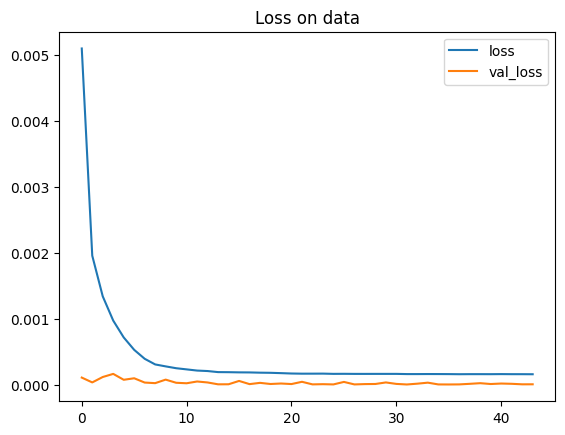

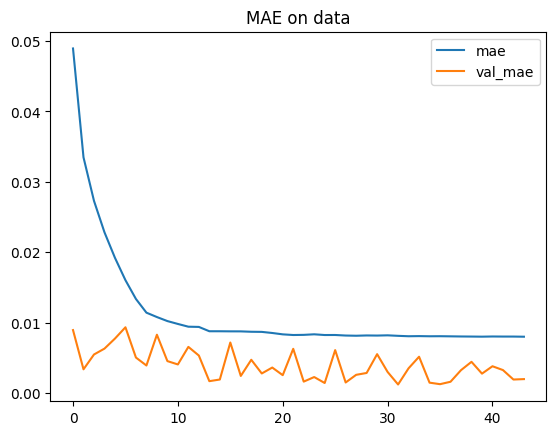

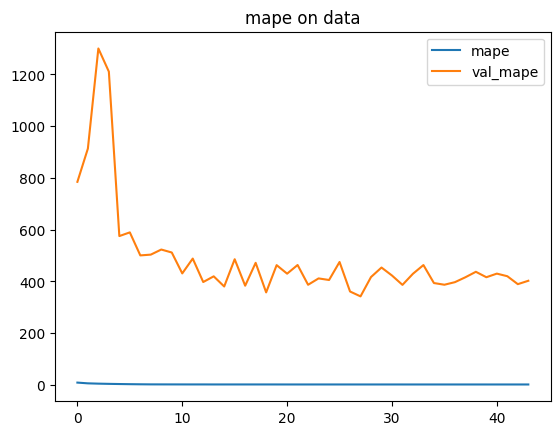

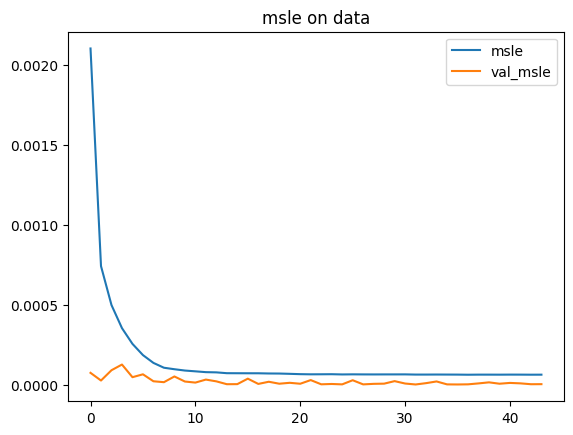

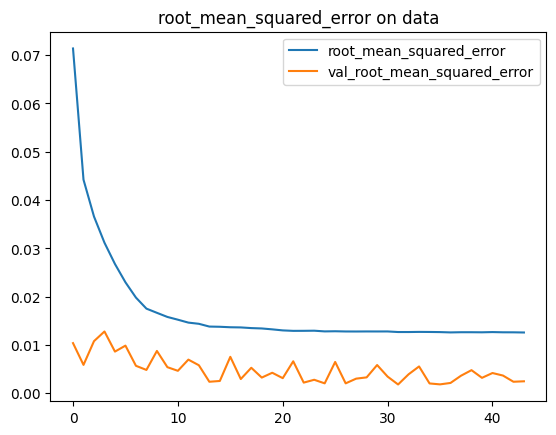

In [ ]:
plt.title("Loss on data")
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

plt.title("MAE on data")
plt.plot(r.history['mae'], label="mae")
plt.plot(r.history['val_mae'], label="val_mae")
plt.legend()
plt.show()

plt.title("mape on data")
plt.plot(r.history['mape'], label="mape")
plt.plot(r.history['val_mape'], label="val_mape")
plt.legend()
plt.show()

plt.title("msle on data")
plt.plot(r.history['msle'], label="msle")
plt.plot(r.history['val_msle'], label="val_msle")
plt.legend()
plt.show()

plt.title("root_mean_squared_error on data")
plt.plot(r.history['root_mean_squared_error'], label="root_mean_squared_error")
plt.plot(r.history['val_root_mean_squared_error'], label="val_root_mean_squared_error")
plt.legend()
plt.show()




In [ ]:
best_model = load_model(m_label + 'lstm_best.keras')


In [ ]:
y_pred = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step


In [ ]:
print(y_pred.shape)

(1101, 3)


In [ ]:
_,y_test = inverse_transform_data(scaled_y=y_test)
_,y_pred = inverse_transform_data(scaled_y=y_pred)
print(y_test, " comparing to ", y_pred)

[[1.34684 1.34622 1.34665]
 [1.34622 1.34665 1.3467 ]
 [1.34665 1.3467  1.34701]
 ...
 [1.33599 1.3355  1.3354 ]
 [1.3355  1.3354  1.33536]
 [1.3354  1.33536 1.33575]]  comparing to  [[1.346259  1.3464376 1.3464192]
 [1.3462805 1.34646   1.3464395]
 [1.3462123 1.3463906 1.3463705]
 ...
 [1.3355799 1.3357632 1.3357447]
 [1.3353603 1.3355461 1.3355238]
 [1.33516   1.3353486 1.3353221]]


In [ ]:
# 1. Calculate the error (the gap between actual and predicted)
error = y_test - y_pred

# 2. Calculate the average gap (the bias)
average_gap = np.mean(error)
print(f"Average Gap (Bias): {average_gap:.7f}")

# 3. Add the average gap to your predictions to create a corrected version
y_pred_corrected = y_pred + average_gap

# --- Verification ---
# Let's check the first predicted value vs. the first actual value
print("\n--- Example of Correction ---")
print(f"Original Prediction: {y_pred[0, 0]:.7f}")
print(f"Corrected Prediction: {y_pred_corrected[0, 0]:.7f}")
print(f"Actual Value:        {y_test[0, 0]:.7f}")

Average Gap (Bias): 0.0003620

--- Example of Correction ---
Original Prediction: 1.3462590
Corrected Prediction: 1.3466210
Actual Value:        1.3468400


In [ ]:
print("R^2 value for ", m_label)
print(r2_score(y_test, y_pred))

R^2 value for  GeneratedGBPUSD
0.9354952505438265


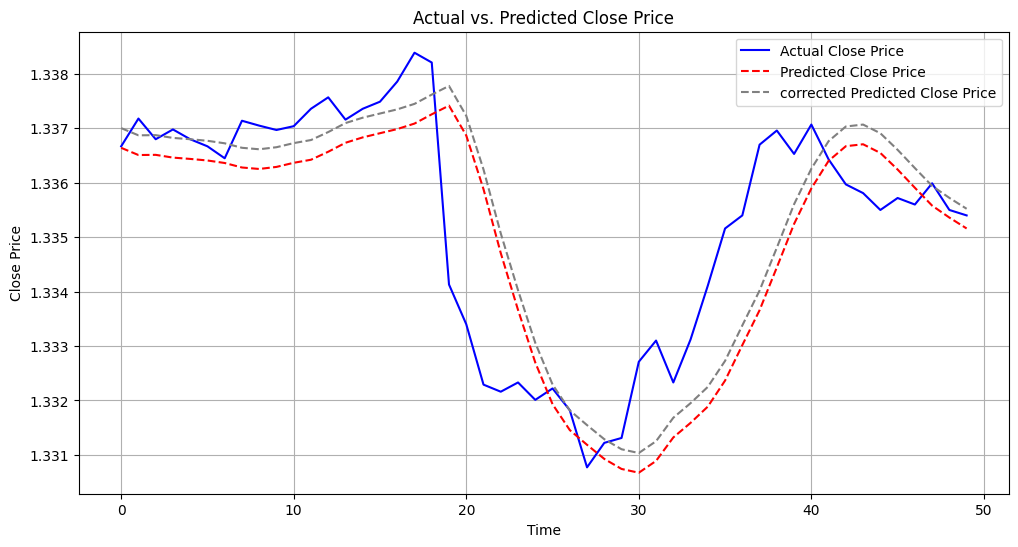

In [ ]:




plt.figure(figsize=(12, 6))
plt.plot(y_test[-50:, 0], label='Actual Close Price', color='blue')
plt.plot(y_pred[-50:, 0], label='Predicted Close Price', color='red', linestyle='--')
plt.plot(y_pred_corrected[-50:, 0], label='corrected Predicted Close Price', color='gray', linestyle='--')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()
